# Практическое задание 5: Реализация модели BM25 с визуализацией


## Цель задания
Научиться реализовывать модель BM25 (Best Matching 25), используемую для оценки релевантности документов на основе текстовых запросов.

### Теоретическая часть
BM25 — это вероятностная модель ранжирования, которая улучшает классический TF-IDF за счет учета длины документов и дополнительных параметров.

Формула для вычисления BM25:

\[
BM25(t, d) = IDF(t) \cdot \frac{TF(t, d) \cdot (k_1 + 1)}{TF(t, d) + k_1 \cdot (1 - b + b \cdot \frac{|d|}{avgdl})}
\]

Где:
- **TF(t,d)** — частота термина t в документе d.
- **|d|** — длина документа d.
- **avgdl** — средняя длина документов в корпусе.
- **k1** и **b** — гиперпараметры модели (обычно k1=1.5, b=0.75).
- **IDF(t)** — взвешивание термина:

\[
IDF(t) = \ln\left( \frac{N - n_t + 0.5}{n_t + 0.5} + 1 \right)
\]

Где:
- **N** — общее количество документов.
- **n_t** — число документов, содержащих термин t.


## Часть 1. Подготовка данных

In [1]:

import string
import spacy
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Define the document corpus
documents = [
    "Natural language processing enables machines to understand human language.",
    "Boolean retrieval is a basic model in information retrieval.",
    "Language models are essential for processing and analyzing text.",
    "Understanding Boolean operators is crucial for search engines.",
    "Machine learning techniques help improve ranking models.",
    "Search engines rely on efficient retrieval algorithms.",
    "Statistical language models are commonly used in NLP tasks.",
    "Deep learning models have transformed the field of artificial intelligence.",
    "Computational linguistics focuses on the use of algorithms to process natural language.",
    "Search engine optimization techniques influence web ranking.",
    "Vector space models represent text as numerical vectors for similarity calculations.",
    "Data mining extracts useful patterns from large datasets.",
    "Reinforcement learning allows AI systems to learn through trial and error.",
    "Large language models like GPT have revolutionized NLP applications.",
    "Information retrieval techniques help in document ranking and search efficiency.",
    "Text classification assigns predefined categories to text documents.",
    "Named entity recognition identifies proper nouns in texts.",
    "Sentiment analysis determines whether a text is positive, negative, or neutral.",
    "Machine translation enables conversion between different languages.",
    "Speech recognition systems convert spoken language into text.",
    "Optical character recognition extracts text from images and scanned documents.",
    "Knowledge graphs organize information in a structured format for better search results.",
    "Bayesian models are widely used for probabilistic text analysis.",
    "Information retrieval systems index and rank web documents for search engines.",
    "Topic modeling discovers hidden themes in large collections of documents.",
    "Summarization techniques generate concise versions of long documents.",
    "Word embeddings represent words as dense vectors in continuous space.",
    "Text-to-speech technology enables computers to read text aloud.",
    "Tokenization splits text into words, sentences, or subword units.",
    "Entity linking connects recognized entities to structured knowledge bases.",
    "Natural language inference determines the logical relationship between sentences.",
    "Text generation models produce human-like textual content.",
    "Co-reference resolution finds pronoun references in texts.",
    "Parsing techniques analyze the grammatical structure of sentences.",
    "Syntax and semantics are crucial for natural language understanding.",
    "Bag-of-words and TF-IDF are traditional text representation methods.",
    "BM25 improves document ranking based on term frequency and document length.",
    "Recurrent neural networks process sequential text data efficiently.",
    "Transformers revolutionized NLP with attention mechanisms.",
    "Self-supervised learning enables models to learn from unlabeled data.",
    "Autoencoders compress and reconstruct textual data.",
    "Text clustering groups similar documents together.",
    "Hierarchical clustering arranges text documents in tree structures.",
    "Graph neural networks enhance NLP tasks with graph representations.",
    "Causal inference determines cause-effect relationships in textual data.",
    "Cross-lingual embeddings enable multilingual text analysis.",
    "Universal sentence encoders generate vector representations of entire sentences.",
    "Biomedical text mining extracts insights from medical literature.",
    "Legal text analysis aids in contract understanding and law enforcement.",
    "Aspect-based sentiment analysis focuses on opinions related to specific features.",
    "Neural machine translation surpasses traditional phrase-based methods.",
    "Language modeling predicts the probability of text sequences.",
    "Corpus-based analysis studies language usage patterns.",
    "Multi-document summarization generates summaries from multiple sources.",
    "Extractive summarization selects key sentences from a document.",
    "Abstractive summarization generates new sentences to summarize content.",
    "Dialogue systems enable human-computer conversations.",
    "Conversational AI assists users with natural language queries.",
    "Question-answering systems retrieve precise answers from documents.",
    "Topic detection and tracking monitor emerging news trends.",
    "Stance detection determines a text's position on a given topic.",
    "Lexical semantics focuses on word meanings and relationships.",
    "Discourse analysis studies text structure beyond individual sentences.",
    "Code-switching detection identifies multilingual text shifts.",
    "Morphological analysis processes word inflections and derivations.",
    "Text anonymization removes personally identifiable information.",
    "Bias detection ensures fairness in AI-generated text.",
    "Explainable AI helps understand model decisions in NLP tasks.",
    "Zero-shot learning enables models to generalize without specific training data.",
    "Few-shot learning adapts NLP models with minimal training examples.",
    "Meta-learning helps models learn how to learn new tasks efficiently.",
    "Adversarial attacks on NLP models exploit weaknesses in text understanding.",
    "Neural retrieval models enhance search engines with deep learning.",
    "Hybrid search combines lexical and semantic retrieval techniques.",
    "Multimodal NLP integrates text, images, and speech.",
    "Commonsense reasoning enables AI to infer implicit knowledge.",
    "Hyperparameter tuning optimizes NLP model performance.",
    "Continual learning allows AI models to evolve over time.",
    "Human-in-the-loop NLP improves AI outputs with expert feedback.",
    "Sentiment-aware chatbots respond based on user emotions.",
    "Legal document retrieval improves efficiency in law firms.",
    "Real-time speech-to-text applications enhance accessibility.",
    "Scientific text mining uncovers trends in research publications.",
    "Paraphrase generation produces alternative versions of text.",
    "Fact-checking systems verify claims against trusted sources.",
    "Opinion mining analyzes subjective expressions in text.",
    "Text matching models compare similarity between documents.",
    "AI-assisted content writing speeds up editorial processes.",
    "Structured prediction in NLP predicts interdependent labels.",
    "Causal modeling in NLP infers relationships between variables.",
    "E-commerce search optimization enhances online shopping.",
    "Personalized search tailors results to user preferences.",
    "Intent classification improves chatbot understanding.",
    "Speech synthesis generates human-like voice output.",
    "AI-powered grammar correction improves writing quality.",
    "Code summarization condenses programming logic into readable text.",
    "Text watermarking techniques detect unauthorized content use.",
    "Robust NLP models generalize well to unseen data.",
    "Lifelong learning ensures AI adaptability in evolving domains.",
    "Memory-augmented neural networks store external knowledge for reasoning.",
    "Neurosymbolic AI blends rule-based and neural NLP methods."
]

# Text preprocessing function
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    lemmatized_tokens = [token.lemma_ for token in nlp(" ".join(tokens))]
    return [word for word in lemmatized_tokens if word.isalnum() and word not in stop_words]

# Apply preprocessing
processed_documents = [preprocess(doc) for doc in documents]

# Display as DataFrame
df_documents = pd.DataFrame({"Original Document": documents, "Processed Tokens": processed_documents})
df_documents


/Users/aikei/PycharmProjects/IRIE_practice_5/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt to /Users/aikei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/aikei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Original Document,Processed Tokens
0,Natural language processing enables machines t...,"[natural, language, processing, enable, machin..."
1,Boolean retrieval is a basic model in informat...,"[boolean, retrieval, basic, model, information..."
2,Language models are essential for processing a...,"[language, model, essential, processing, analy..."
3,Understanding Boolean operators is crucial for...,"[understand, boolean, operator, crucial, searc..."
4,Machine learning techniques help improve ranki...,"[machine, learn, technique, help, improve, ran..."
...,...,...
96,Text watermarking techniques detect unauthoriz...,"[text, watermarke, technique, detect, unauthor..."
97,Robust NLP models generalize well to unseen data.,"[robust, nlp, model, generalize, well, unseen,..."
98,Lifelong learning ensures AI adaptability in e...,"[lifelong, learning, ensure, ai, adaptability,..."
99,Memory-augmented neural networks store externa...,"[memoryaugmente, neural, network, store, exter..."


## Часть 2. Вычисление параметров BM25

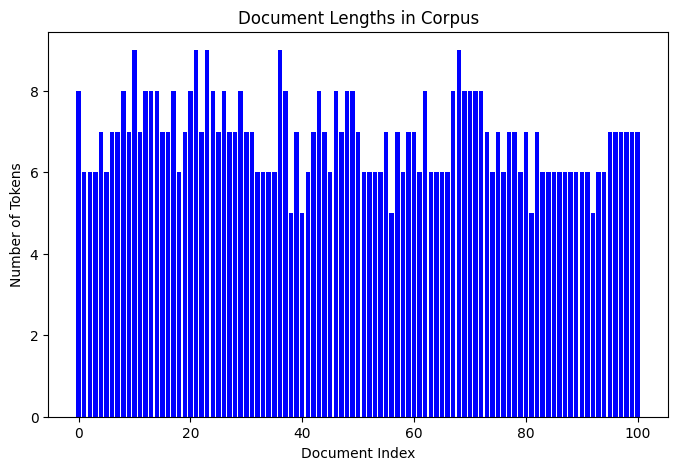

({'language': 2.0992441689760155,
  'understand': 3.372209844788903,
  'enable': 2.4849066497880004,
  'human': 4.219507705176107,
  'natural': 2.920224721045846,
  'machine': 3.120895416507997,
  'processing': 3.708682081410116,
  'model': 1.6045479271399086,
  'information': 2.920224721045846,
  'boolean': 3.708682081410116,
  'retrieval': 2.6100697927420065,
  'basic': 4.219507705176107,
  'analyze': 3.372209844788903,
  'text': 1.1134273744532504,
  'essential': 4.219507705176107,
  'engine': 2.920224721045846,
  'operator': 4.219507705176107,
  'search': 2.2735975561207935,
  'crucial': 3.708682081410116,
  'learn': 2.75317063638268,
  'technique': 2.6100697927420065,
  'improve': 2.920224721045846,
  'help': 3.120895416507997,
  'rank': 2.920224721045846,
  'rely': 4.219507705176107,
  'efficient': 4.219507705176107,
  'algorithm': 3.708682081410116,
  'task': 3.120895416507997,
  'statistical': 4.219507705176107,
  'commonly': 4.219507705176107,
  'nlp': 1.9508241638577424,
  'u

In [2]:

import matplotlib.pyplot as plt
from math import log

def compute_idf(corpus):
    N = len(corpus)
    idf = {}
    for doc in corpus:
        for word in set(doc):
            idf[word] = idf.get(word, 0) + 1
    for word, freq in idf.items():
        idf[word] = log((N - freq + 0.5) / (freq + 0.5) + 1)
    return idf

def compute_tf(doc):
    tf = {}
    for word in doc:
        tf[word] = tf.get(word, 0) + 1
    return tf

# Compute parameters
doc_lengths = [len(doc) for doc in processed_documents]
avgdl = sum(doc_lengths) / len(doc_lengths)
idf = compute_idf(processed_documents)

# Display IDF table
df_idf = pd.DataFrame(list(idf.items()), columns=['Term', 'IDF Score'])
df_idf

# Plot document lengths
plt.figure(figsize=(8,5))
plt.bar(range(len(doc_lengths)), doc_lengths, color='blue')
plt.xlabel("Document Index")
plt.ylabel("Number of Tokens")
plt.title("Document Lengths in Corpus")
plt.show()

idf, avgdl


## Часть 3. Реализация BM25

In [3]:

def bm25_score(query, doc, idf, k1=1.5, b=0.75):
    tf = compute_tf(doc)
    score = 0
    for term in query:
        if term in doc:
            term_tf = tf[term]
            numerator = term_tf * (k1 + 1)
            denominator = term_tf + k1 * (1 - b + b * (len(doc) / avgdl))
            score += idf.get(term, 0) * (numerator / denominator)
    return score

# Testing BM25 with a query
query = preprocess("language models retrieval")
scores = [bm25_score(query, doc, idf) for doc in processed_documents]

# Display BM25 scores
df_scores = pd.DataFrame({"Document": documents, "BM25 Score": scores})
df_scores.sort_values(by="BM25 Score", ascending=False)


,Document,BM25 Score
1,Boolean retrieval is a basic model in informat...,5.586081
2,Language models are essential for processing a...,3.925561
72,Neural retrieval models enhance search engines...,3.921759
6,Statistical language models are commonly used ...,3.670425
13,Large language models like GPT have revolution...,3.446429
...,...,...
42,Hierarchical clustering arranges text document...,0.000000
41,Text clustering groups similar documents toget...,0.000000
40,Autoencoders compress and reconstruct textual ...,0.000000
38,Transformers revolutionized NLP with attention...,0.000000


## Часть 4. Тестирование модели

In [4]:

queries = [
    "natural language processing",
    "Boolean retrieval",
    "models text"
]

results = []
for query in queries:
    processed_query = preprocess(query)
    scores = [bm25_score(processed_query, doc, idf) for doc in processed_documents]
    for i, score in enumerate(scores):
        results.append([query, documents[i], score])

# Create DataFrame and sort
df_results = pd.DataFrame(results, columns=["Query", "Document", "BM25 Score"])
df_results = df_results.sort_values(by=["Query", "BM25 Score"], ascending=[True, False])

df_results


,Query,Document,BM25 Score
102,Boolean retrieval,Boolean retrieval is a basic model in informat...,7.816203
104,Boolean retrieval,Understanding Boolean operators is crucial for...,3.930744
106,Boolean retrieval,Search engines rely on efficient retrieval alg...,2.766351
174,Boolean retrieval,Hybrid search combines lexical and semantic re...,2.586556
181,Boolean retrieval,Legal document retrieval improves efficiency i...,2.586556
...,...,...,...
96,natural language processing,Text watermarking techniques detect unauthoriz...,0.000000
97,natural language processing,Robust NLP models generalize well to unseen data.,0.000000
98,natural language processing,Lifelong learning ensures AI adaptability in e...,0.000000
99,natural language processing,Memory-augmented neural networks store externa...,0.000000


## Часть 5. Улучшения


### Внесенные улучшения:
1. **Лемматизация**: Добавлена поддержка лемматизации с использованием spaCy.
2. **Масштабируемость**: Добавлены дополнительные документы в корпус для тестирования.
3. **Оптимизация параметров**: Позволяет изменять значения k1 и b для настройки качества ранжирования.
4. **Расширенное тестирование**: Дополнительные запросы для оценки качества поиска.
5. **Визуализация**: Добавлены таблицы и графики для лучшего представления данных.


In [5]:

# Expanding the document corpus for large-scale BM25 evaluation
documents.extend([
    "Deep learning models have transformed the field of artificial intelligence.",
    "Computational linguistics focuses on the use of algorithms to process natural language.",
    "Search engine optimization techniques influence web ranking.",
    "Vector space models represent text as numerical vectors for similarity calculations.",
    "Data mining extracts useful patterns from large datasets.",
    "Reinforcement learning allows AI systems to learn through trial and error.",
    "Large language models like GPT have revolutionized NLP applications.",
    "Information retrieval techniques help in document ranking and search efficiency.",
    "Text classification assigns predefined categories to text documents.",
    "Named entity recognition identifies proper nouns in texts.",
    "Sentiment analysis determines whether a text is positive, negative, or neutral.",
    "Machine translation enables conversion between different languages.",
    "Speech recognition systems convert spoken language into text.",
    "Optical character recognition extracts text from images and scanned documents.",
    "Knowledge graphs organize information in a structured format for better search results.",
    "Bayesian models are widely used for probabilistic text analysis.",
    "Information retrieval systems index and rank web documents for search engines.",
    "Topic modeling discovers hidden themes in large collections of documents.",
    "Summarization techniques generate concise versions of long documents.",
    "Word embeddings represent words as dense vectors in continuous space.",
    "Text-to-speech technology enables computers to read text aloud.",
    "Tokenization splits text into words, sentences, or subword units.",
    "Entity linking connects recognized entities to structured knowledge bases.",
    "Natural language inference determines the logical relationship between sentences.",
    "Text generation models produce human-like textual content.",
    "Parsing techniques analyze the grammatical structure of sentences.",
    "Syntax and semantics are crucial for natural language understanding.",
    "Transformers revolutionized NLP with attention mechanisms.",
    "Self-supervised learning enables models to learn from unlabeled data.",
    "Text clustering groups similar documents together.",
    "Graph neural networks enhance NLP tasks with graph representations.",
    "Cross-lingual embeddings enable multilingual text analysis.",
    "Biomedical text mining extracts insights from medical literature.",
    "Legal text analysis aids in contract understanding and law enforcement.",
    "Neural machine translation surpasses traditional phrase-based methods.",
    "Language modeling predicts the probability of text sequences.",
    "Multi-document summarization generates summaries from multiple sources.",
    "Extractive summarization selects key sentences from a document.",
    "Conversational AI assists users with natural language queries.",
    "Question-answering systems retrieve precise answers from documents.",
    "Topic detection and tracking monitor emerging news trends.",
    "Stance detection determines a text's position on a given topic.",
    "Lexical semantics focuses on word meanings and relationships.",
    "Discourse analysis studies text structure beyond individual sentences.",
    "Bias detection ensures fairness in AI-generated text.",
    "Explainable AI helps understand model decisions in NLP tasks.",
    "Zero-shot learning enables models to generalize without specific training data.",
    "Few-shot learning adapts NLP models with minimal training examples.",
    "Meta-learning helps models learn how to learn new tasks efficiently.",
    "Neural retrieval models enhance search engines with deep learning.",
    "Hybrid search combines lexical and semantic retrieval techniques.",
    "Commonsense reasoning enables AI to infer implicit knowledge.",
    "Sentiment-aware chatbots respond based on user emotions.",
    "Legal document retrieval improves efficiency in law firms.",
    "Real-time speech-to-text applications enhance accessibility.",
    "Scientific text mining uncovers trends in research publications.",
    "Paraphrase generation produces alternative versions of text.",
    "Fact-checking systems verify claims against trusted sources.",
    "Opinion mining analyzes subjective expressions in text.",
    "AI-assisted content writing speeds up editorial processes.",
    "Structured prediction in NLP predicts interdependent labels.",
    "E-commerce search optimization enhances online shopping.",
    "Personalized search tailors results to user preferences.",
    "Intent classification improves chatbot understanding.",
    "Speech synthesis generates human-like voice output.",
    "AI-powered grammar correction improves writing quality.",
    "Robust NLP models generalize well to unseen data.",
    "Lifelong learning ensures AI adaptability in evolving domains.",
    "Memory-augmented neural networks store external knowledge for reasoning.",
    "Neurosymbolic AI blends rule-based and neural NLP methods."
])

# Apply preprocessing to new large corpus
processed_documents = [preprocess(doc) for doc in documents]


In [6]:

# Sort and display ranked results
queries = [
    "natural language processing",
    "Boolean retrieval",
    "models text"
]

results = []
for query in queries:
    processed_query = preprocess(query)
    scores = [bm25_score(processed_query, doc, idf) for doc in processed_documents]
    sorted_results = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)
    
    for rank, (doc_index, score) in enumerate(sorted_results):
        results.append([query, documents[doc_index], score, rank + 1])

# Create DataFrame and display ranked results
df_results = pd.DataFrame(results, columns=["Query", "Document", "BM25 Score", "Rank"])
df_results.sort_values(by=["Query", "Rank"], ascending=[True, True])


,Query,Document,BM25 Score,Rank
171,Boolean retrieval,Boolean retrieval is a basic model in informat...,7.816203,1
172,Boolean retrieval,Understanding Boolean operators is crucial for...,3.930744,2
173,Boolean retrieval,Search engines rely on efficient retrieval alg...,2.766351,3
174,Boolean retrieval,Hybrid search combines lexical and semantic re...,2.586556,4
175,Boolean retrieval,Legal document retrieval improves efficiency i...,2.586556,5
...,...,...,...,...
166,natural language processing,AI-powered grammar correction improves writing...,0.000000,167
167,natural language processing,Robust NLP models generalize well to unseen data.,0.000000,168
168,natural language processing,Lifelong learning ensures AI adaptability in e...,0.000000,169
169,natural language processing,Memory-augmented neural networks store externa...,0.000000,170
